## LSTM based simulation with Tensorflow v2.3

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from datetime import timedelta
from tensorflow.python.framework import ops as tf_ops
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [27]:
sns.set()

### Define global variables

In [28]:
csv_filepath:str = "../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv"
print(f"csv_filepath {csv_filepath}")
date_column:str = "Date "
low_column:str = "LOW "
high_column:str = "HIGH "
close_column:str = "close "
volume_column:str = "VOLUME "

csv_filepath ../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv


### Read csv data

In [29]:
df = pd.read_csv(csv_filepath, header=0)
print(f"df keys")
print(f"{df.keys()}")
# Sort DataFrame by date
df[date_column]=pd.to_datetime(df[date_column])
df.head()

df keys
Index(['Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp ',
       'close ', 'vwap ', '52W H ', '52W L ', 'VOLUME ', 'VALUE ',
       'No of trades '],
      dtype='object')


,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2020-08-19,EQ,"1,835.00","1,835.90","1,818.05","1,820.70","1,827.55","1,827.95","1,828.01","2,499.90","1,473.45",2934730,"5,364,712,976.60",85358
1,2020-08-18,EQ,"1,801.10","1,825.40","1,795.95","1,800.55","1,819.05","1,820.70","1,813.53","2,499.90","1,473.45",3413536,"6,190,549,505.40",141811
2,2020-08-17,EQ,"1,805.00","1,807.85","1,783.85","1,791.70","1,801.95","1,800.55","1,795.17","2,499.90","1,473.45",4076960,"7,318,829,944.15",148103
3,2020-08-14,EQ,"1,818.60","1,823.75","1,773.25","1,804.85","1,793.75","1,791.70","1,796.65","2,499.90","1,473.45",6136766,"11,025,637,096.85",186319
4,2020-08-13,EQ,"1,818.50","1,823.65","1,799.55","1,814.20","1,810.00","1,804.85","1,807.52","2,499.90","1,473.45",3769538,"6,813,503,042.60",129725


In [30]:
df[date_column] = df[date_column].astype('datetime64[ns]')
df[low_column] = df[low_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[high_column] = df[high_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[close_column] = df[close_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[volume_column] = df[volume_column].transform(func=lambda x: "".join(str(x).split(","))).astype(int)
df = df.sort_values(by=[date_column], ascending=True)
df.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
485,2018-08-29,EQ,"1,959.40",1971.40,1944.70,"1,955.15","1,949.00",1956.25,"1,958.79","2,052.95","1,638.00",2367281,"4,636,999,492.95",106131
484,2018-08-30,EQ,"1,950.00",1964.45,1928.25,"1,956.25","1,933.00",1934.15,"1,938.39","2,052.95","1,638.00",2466442,"4,780,934,933.15",89377
483,2018-08-31,EQ,"1,940.90",1942.45,1908.05,"1,934.15","1,940.85",1935.95,"1,925.82","2,052.95","1,638.00",3856093,"7,426,153,067.50",152636
482,2018-09-03,EQ,"1,950.00",1950.00,1928.10,"1,935.95","1,943.00",1944.80,"1,939.87","2,052.95","1,638.00",2310201,"4,481,480,074.20",106865
481,2018-09-04,EQ,"1,939.00",1959.65,1939.00,"1,944.80","1,950.75",1954.80,"1,952.12","2,052.95","1,638.00",2928533,"5,716,834,403.55",133601


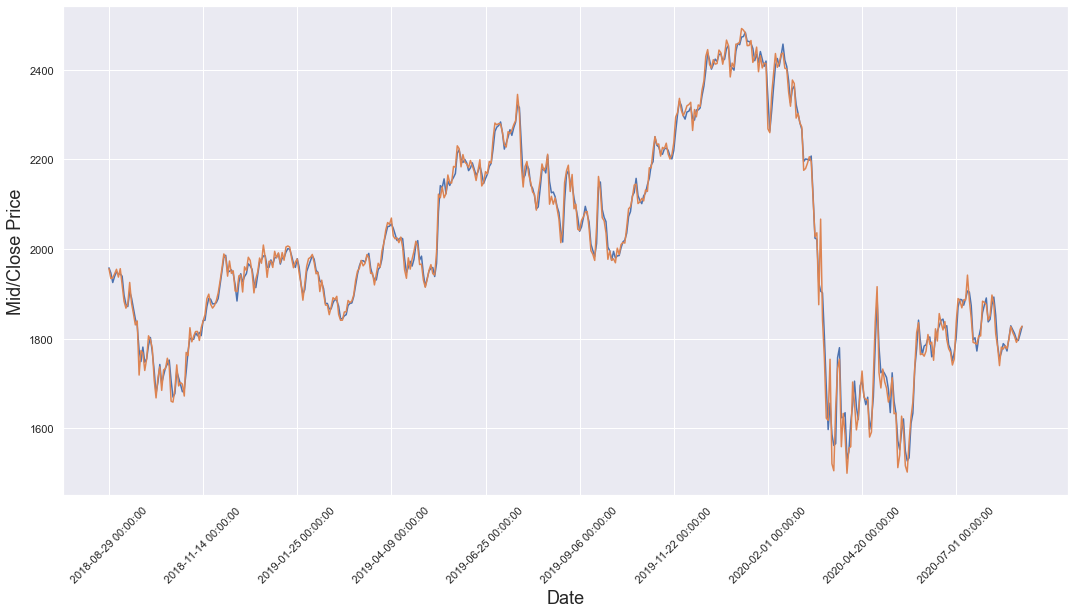

In [31]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df[low_column]+df[high_column])/2.0)
plt.plot(range(df.shape[0]),(df[close_column]))
plt.xticks(range(0,df.shape[0],50),df[date_column].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid/Close Price',fontsize=18)
plt.show()

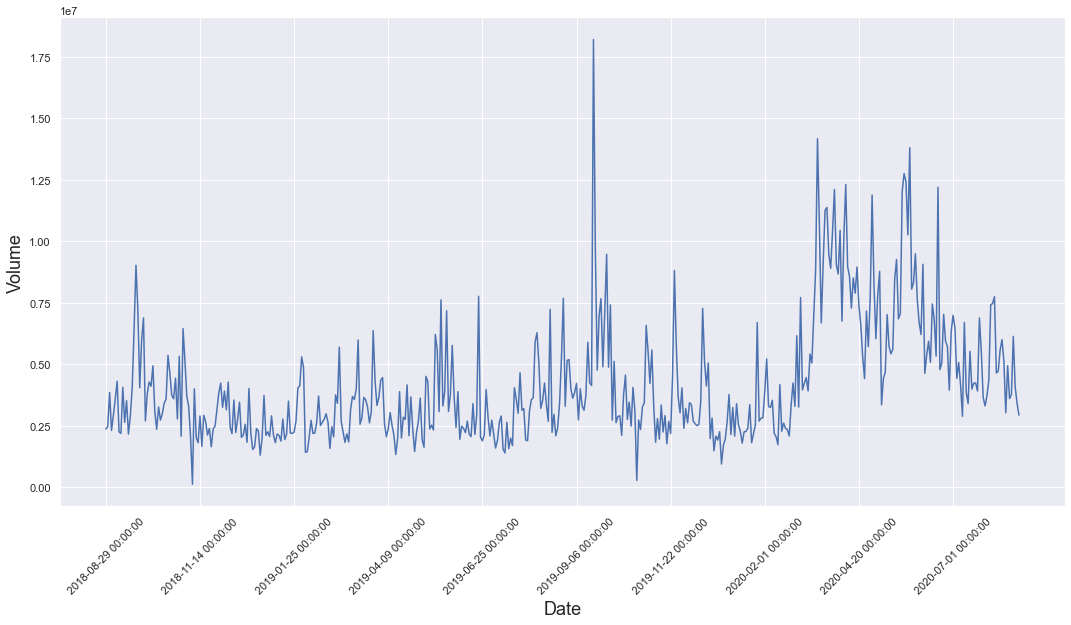

In [32]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df[volume_column]))
plt.xticks(range(0,df.shape[0],50),df[date_column].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Volume',fontsize=18)
plt.show()

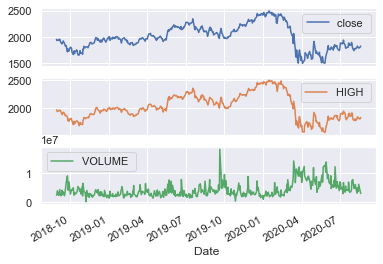

In [33]:
date_time = pd.to_datetime(df[date_column], format='%Y-%m-%d')

plot_cols = [close_column, high_column, volume_column]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

## Data inspection and cleanup

In [34]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HIGH,486.0,2.029387e+03,2.234151e+02,1568.15,1860.075,1990.850,2196.500,2499.9
LOW,486.0,1.976023e+03,2.331954e+02,1473.45,1811.150,1951.650,2153.275,2471.8
close,486.0,2.002078e+03,2.304987e+02,1499.55,1835.925,1973.925,2178.675,2492.3
VOLUME,486.0,4.179665e+06,2.460386e+06,124505.00,2426419.500,3435599.500,5139375.250,18203636.0
No of trades,486.0,1.603050e+05,6.635073e+04,5664.00,114562.750,145103.000,190807.250,454758.0


## Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

    It ensures that chopping the data into windows of consecutive samples is still possible.
    It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.


In [37]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
train_df.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
485,2018-08-29,EQ,"1,959.40",1971.40,1944.70,"1,955.15","1,949.00",1956.25,"1,958.79","2,052.95","1,638.00",2367281,"4,636,999,492.95",106131
484,2018-08-30,EQ,"1,950.00",1964.45,1928.25,"1,956.25","1,933.00",1934.15,"1,938.39","2,052.95","1,638.00",2466442,"4,780,934,933.15",89377
483,2018-08-31,EQ,"1,940.90",1942.45,1908.05,"1,934.15","1,940.85",1935.95,"1,925.82","2,052.95","1,638.00",3856093,"7,426,153,067.50",152636
482,2018-09-03,EQ,"1,950.00",1950.00,1928.10,"1,935.95","1,943.00",1944.80,"1,939.87","2,052.95","1,638.00",2310201,"4,481,480,074.20",106865
481,2018-09-04,EQ,"1,939.00",1959.65,1939.00,"1,944.80","1,950.75",1954.80,"1,952.12","2,052.95","1,638.00",2928533,"5,716,834,403.55",133601


In [36]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


<ipython-input-36-4f3366c38cf3>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  train_mean = train_df.mean()


UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('float64')